# Historical Network Constrained Linear Optimal Power Flow

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a historical 3 day period.

In [2]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [3]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [2]:
# write csv files for import
start = '2019-12-01 00:00:00'
end = '2019-12-03 23:30:00'
# year of simulation
year = 2019
# time step as fraction of hour
time_step = 0.5

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [3]:
data_reader_writer.data_writer(start, end, time_step, year)

C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [4]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import. 
Currently used PyPSA version [0, 18, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, loads, storage_units


To approximate n-1 security and allow room for reactive power flows, don't allow any line to be loaded above 70% of their thermal rating

In [5]:
contingency_factor = 0.7
network.lines.s_max_pu[0:99] *= contingency_factor

## Running the optimisation

In [6]:
network.lopf(network.snapshots, solver_name="gurobi")

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x400321_copy
  Lower bound: 57759095.217732854
  Upper bound: 57759095.217732854
  Number of objectives: 1
  Number of constraints: 808275
  Number of variables: 400321
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 400321
  Number of nonzeros: 1998721
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termin

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [7]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# interconnector exports
exports = network.loads_t.p
# multiply by negative one to convert it as a generator
# i.e. export is a positive load, but negative generator
exports['Interconnectors Export'] = exports.iloc[:, -6:].sum(axis=1) * -1
interconnector_export = exports[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

carrier,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),Coal,EfW Incineration,Interconnectors Import,Landfill Gas,Hydro,Natural Gas,Nuclear,Oil,Sewage Sludge Digestion,Shoreline Wave,Small Hydro,Solar Photovoltaics,Tidal Barrage and Tidal Stream,Wind Offshore,Wind Onshore,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,
2019-12-01 00:00:00,317.600000,0.0,0.0,0.0,1250.2,3996.0,743.5,283.227801,10792.935727,9314.0,0.0,50.2,24.0,36.772199,0.0,10.5,2638.214991,1048.849282,740.000000,1111.300000
2019-12-01 00:30:00,317.600000,0.0,0.0,0.0,1250.2,3997.0,743.5,281.457627,9983.717528,9314.0,0.0,50.2,24.0,36.542373,0.0,10.5,2526.737364,1082.545108,740.000000,1111.300000
2019-12-01 01:00:00,317.600000,0.0,0.0,0.0,1250.2,3997.0,743.5,280.572540,9687.155351,9314.0,0.0,50.2,24.0,36.427460,0.0,10.5,2482.670493,1095.174156,740.000000,1111.300000
2019-12-01 01:30:00,317.600000,0.0,0.0,0.0,1250.2,3998.0,743.5,280.572540,9582.374535,9314.0,0.0,50.2,24.0,36.427460,0.0,10.5,2506.014377,1101.611088,740.000000,1111.300000
2019-12-01 02:00:00,317.600000,0.0,0.0,0.0,1250.2,3998.0,743.5,271.721671,9245.435816,9314.0,0.0,50.2,24.0,35.278329,0.0,10.5,2530.801553,1120.762631,740.000000,1111.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03 21:30:00,312.600000,0.0,99.6,0.0,1250.2,2463.0,723.3,232.571687,19022.092523,9206.9,0.0,50.2,24.0,23.870580,0.0,10.5,2173.181209,4720.815096,2150.168904,1185.700000
2019-12-03 22:00:00,317.553953,0.0,99.6,0.0,1250.2,2159.0,726.7,281.402462,19111.070000,9191.6,0.0,50.2,24.0,32.727854,0.0,10.5,2093.402636,4362.951631,816.091463,1194.053953
2019-12-03 22:30:00,312.600000,0.0,99.6,0.0,1250.2,2049.0,729.1,272.406780,18047.364455,9176.3,0.0,50.2,24.0,30.350282,0.0,10.5,2090.567636,4140.073316,7.737532,1191.500000


Graph the power output of the different generation types...

C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

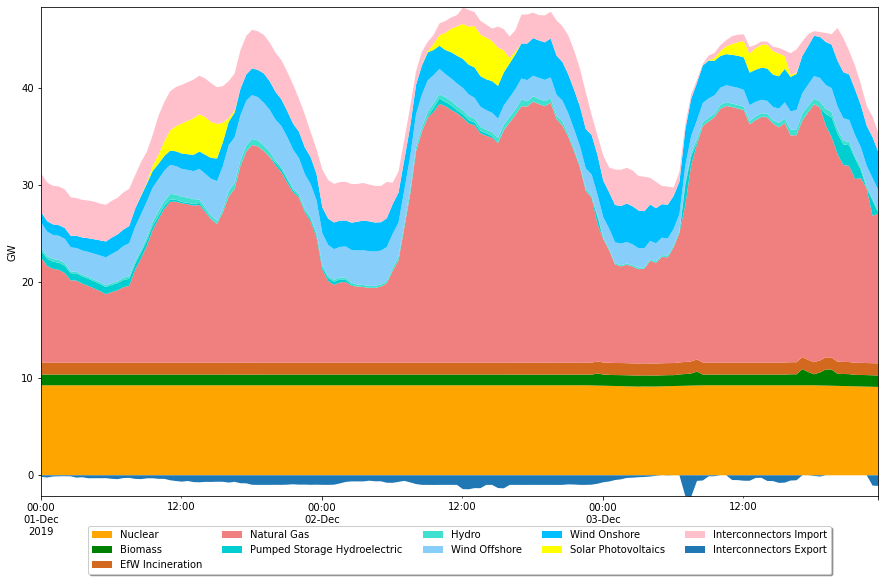

In [8]:
cols = ["Nuclear", 'Shoreline Wave', 'Biomass',
        'EfW Incineration',
        "Coal", "Oil", "Natural Gas",
        "Pumped Storage Hydroelectric", 'Hydro',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting storage

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

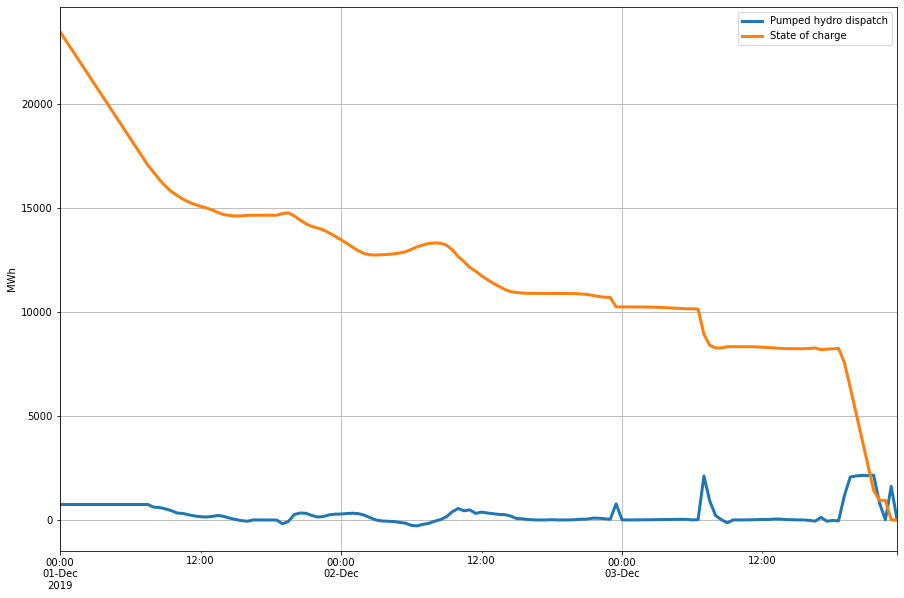

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

## Plotting line loading

Look at the line loading stats and graph...

In [10]:
now = network.snapshots[139]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    105.000000
mean       0.127009
std        0.229369
min       -0.270731
25%       -0.010994
50%        0.084382
75%        0.231317
max        0.700000
dtype: float64

(<matplotlib.collections.PatchCollection at 0x1dd5795bfd0>,
 <matplotlib.collections.LineCollection at 0x1dd577f9be0>)

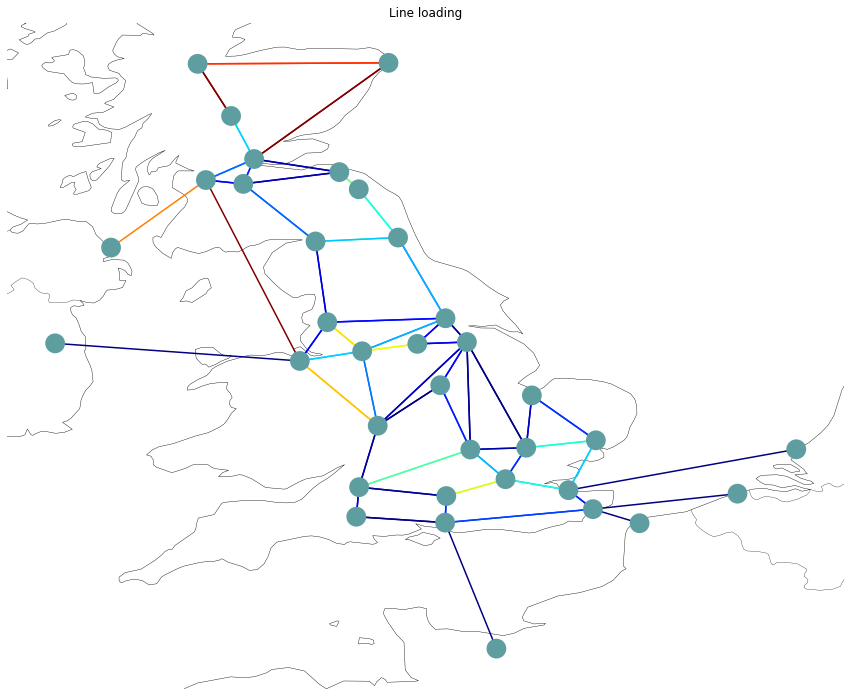

In [11]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

## Plotting locational marginal prices

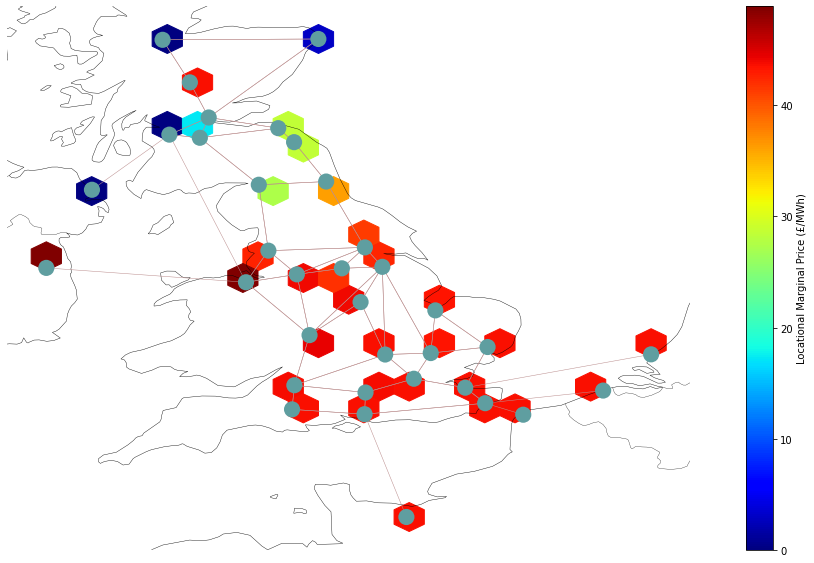

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

In [13]:
network.buses_t.marginal_price

name,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Kemsley,Sellindge,Lovedean,S.W.Penisula,Netherlands,Belgium,France1,France2,Ireland,N. Ireland
snapshot,,,,,,,,,,,,,,,,,,,,,
2019-12-01 00:00:00,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,...,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195
2019-12-01 00:30:00,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,...,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195
2019-12-01 01:00:00,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,...,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195
2019-12-01 01:30:00,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,...,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195
2019-12-01 02:00:00,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,...,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195,43.874195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03 21:30:00,0.000000,2.906604,43.747186,17.885474,0.000000,16.843500,28.557646,28.600868,27.437625,36.164723,...,43.610187,43.652143,43.711448,43.729092,43.610187,43.652143,43.652143,43.711448,48.911252,0.000000
2019-12-03 22:00:00,0.000000,2.906604,43.747186,17.885474,0.000000,16.843500,28.557646,28.600868,27.437625,36.164723,...,43.610187,43.652143,43.711448,43.729092,43.610187,43.652143,43.652143,43.711448,48.911252,0.000000
2019-12-03 22:30:00,0.000000,2.906604,43.747186,17.885474,0.000000,16.843500,28.557646,28.600868,27.437625,36.164723,...,43.610187,43.652143,43.711448,43.729092,43.610187,43.652143,43.652143,43.711448,48.911252,0.000000


## Plotting curtailment

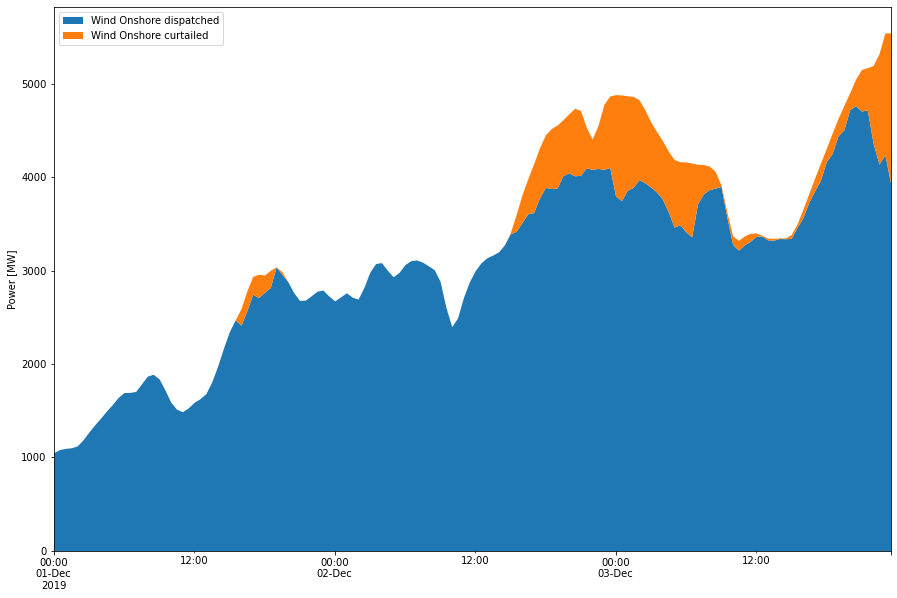

In [14]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()